<a href="https://colab.research.google.com/github/EVA6-Group-15/CIFAR_85/blob/master/notebooks/CIFAR10_03_ImgAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Information

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.89GB
Used: 537.24MB
Percentage: 6.3%


In [ ]:
! nvidia-smi

Thu Jun 17 18:45:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Module Imports

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git ./DLUtils
!cp -r ./DLUtils/src/dlutils/ ./utils
!rm -r DLUtils

In [ ]:
from Utils.data.pytorch_data import GetData
from Utils.data.transformations import * #HELPER, generate_compose
from Utils.visualization import plot_inference, plotter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# Data

## Finding Data Stats

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

LOADER_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [ ]:
cifar = GetData('CIFAR10')

In [ ]:
train_data = cifar.build_data(train=True)
test_data = cifar.build_data(train=False)

In [ ]:
loader = DataLoader(
    train_data,
    batch_size=1000,
    num_workers=1,
    shuffle=False
)

mean, std = plotter.data_stats(loader)

Train Statistics
Image Shape:  torch.Size([3, 32, 32])
 - mean: [tensor(0.4914), tensor(0.4822), tensor(0.4465)]
 - std: [tensor(0.2470), tensor(0.2434), tensor(0.2615)]


## Creating Augmentations for Data

In [ ]:
album_help = HELPER()

In [ ]:
album_help.functions()

use <object_name>.<function_name> to know more about each. Eg: <object_name>.Blur
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1. 'Blur' - Blur the Input Image using Rnadom Size Kernel.
2. 'CoarseDropout' - CoarseDropout of Rectangular Regions in the Image.
3. 'ColorJitter' - Randomly changes the brightness, contrast, and saturation of an Image.
4. 'Cutout' - CoarseDropout of the square regions in the Image.
5. 'Flip' - Flip the Image either horizontally, vertically or both horizontally and vertically.
6. 'HorizontalFlip' - Flip the Image horizontally around the y-axis
7. 'VerticalFlip' - Flip the Image vertically around the x-axis
8. 'GaussianBlur' - Blur the input Image using a Gaussian filter with a random kernel size.
9. 'ShiftScaleRotate' - Randomly apply affine transforms: translate, scale and rotate the input.
10. 'Normalize' - Normalization is applied by the formula: **img = (img - mean * max_pixel_value) / (std * max_pixel_value)**.
Note: T

In [ ]:
album_help.ShiftScaleRotate

" {ShiftScaleRotate: {'shift_limit': 0.0625, 'scale_limit': 0.1, 'rotate_limit': 45, 'interpolation': 1, 'border_mode': 4, 'value': None, 'mask_value': None, 'shift_limit_x': None, 'shift_limit_y': None, 'always_apply': False, 'p': 0.5}, ... }"

In [ ]:
album_help.HorizontalFlip

" {HorizontalFlip: {'always_apply': False, 'p': 0.5}, ... }"

In [ ]:
album_help.CoarseDropout

" {CoarseDropout: {'max_holes': 8, 'max_height': 8, 'max_width': 8, 'min_holes': None, 'min_height': None, 'min_width': None, 'fill_value': 0, 'mask_fill_value': None, 'always_apply': False, 'p': 0.5}, ... }"

In [ ]:
album_help.ToGray

" {ToGray: {'always_apply': False, 'p': 0.5}, ... }"

In [ ]:
transformations = {
    'ShiftScaleRotate': {'shift_limit': 0.05, 'scale_limit': 0.1, 'rotate_limit': 7,},
    'HorizontalFlip': {},
    'CoarseDropout': {'max_holes': 1, 'max_height':16, 'max_width':16, 'min_holes': 1, 
                      'min_height':16, 'min_width':16, 'fill_value':[0.4914, 0.4822, 0.4465], 
                      'mask_fill_value': None},
    'ToGray': {}
}

In [ ]:
train_trans = generate_compose(mean, std, **transformations) # Normalize and ToTensor by Default along with Transformations
test_trans = generate_compose(mean, std) # Normalize and ToTensor by Default. No other Transformations

In [ ]:
train_data = cifar.build_data(train_trans, train=True)
test_data = cifar.build_data(test_trans, train=False)
train_loader = cifar.build_loader(train_data, 64, **LOADER_kwargs)
test_loader = cifar.build_loader(test_data, 64, **LOADER_kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = train_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Training Data

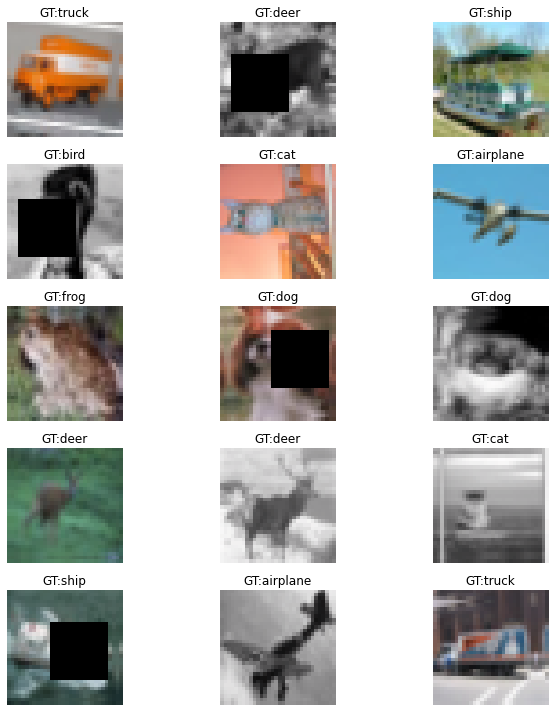

In [ ]:
from Utils.visualization import plot_inference, plotter
plotter.plot_data_grid(train_loader, mean= mean, std= std, class_list=classes, ncol=3,nrow=5)

#### The CutOut is NOT black, it mean, but since we are UnNormaziling the Images before plotting, the CutOut values changes from mean to black

### Test Data

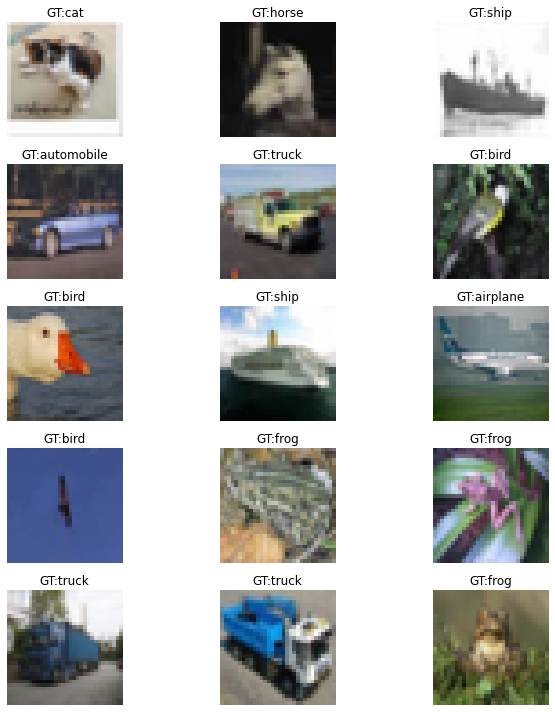

In [ ]:
plotter.plot_data_grid(test_loader, mean= mean, std= std, class_list=classes, ncol=3,nrow=5)

# Model

In [ ]:
from Utils.models.CIFAR10.model_ImgAug import Net

In [ ]:
model = Net().to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 16, 16]           9,216
       BatchNorm2d-8           [-1, 32, 16, 16]              64
              ReLU-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           9,216
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           9,216
      BatchNorm2d-14           [-1, 32,

In [ ]:
from Utils.features.runner import run

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
ai = run.Run(model, train_loader, test_loader, 100, DEVICE, optimizer)
ai()

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


loss=1.158664345741272 batch_id=781: 100%|██████████| 782/782 [00:20<00:00, 38.26it/s]


TRAIN set: Average loss: 1.7847, Train Accuracy: 33.42% | TEST set: Average loss: 1.5021, Test Accuracy: 45.49%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 1.3866, Train Accuracy: 49.49% | TEST set: Average loss: 1.1603, Test Accuracy: 57.89%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 1.1919, Train Accuracy: 57.09% | TEST set: Average loss: 1.0232, Test Accuracy: 63.53%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 1.0643, Train Accuracy: 62.22% | TEST set: Average loss: 0.8850, Test Accuracy: 68.80%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.9987, Train Accuracy: 65.00% | TEST set: Average loss: 0.7994, Test Accuracy: 72.18%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.9417, Train Accuracy: 66.90% | TEST set: Average loss: 0.7959, Test Accur

In [ ]:
print('Train Accuracy:', max(ai.metrics['train_accuracy']))
print('Test Accuracy:', max(ai.metrics['test_accuracy']))

Train Accuracy: 83.124
Test Accuracy: 86.23


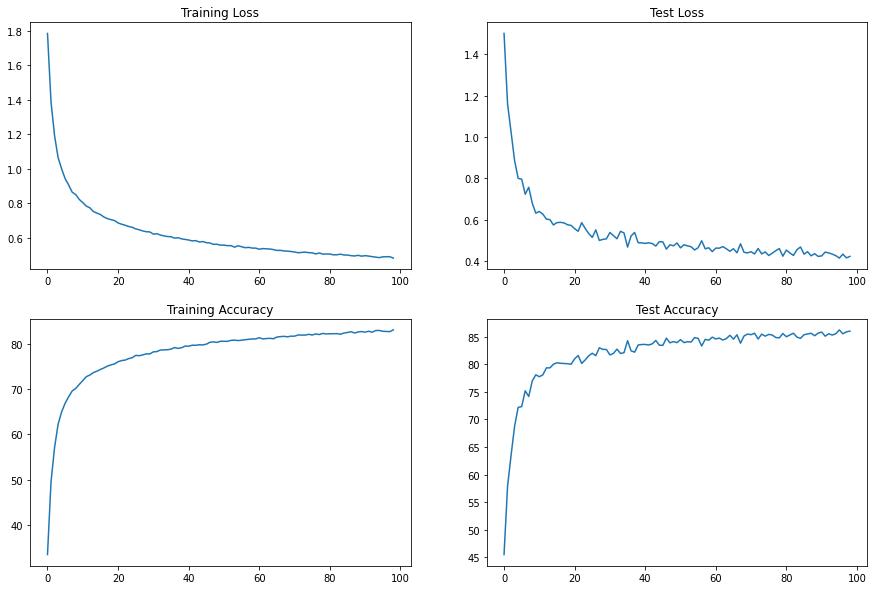

In [ ]:
plotter.plot_loss_acc(ai.metrics['train_loss'], ai.metrics['train_accuracy'], ai.metrics['test_loss'], ai.metrics['test_accuracy'])

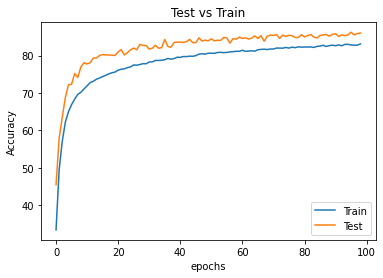

In [ ]:
plotter.plot_combined([ai.metrics['train_accuracy'], ai.metrics['test_accuracy']])

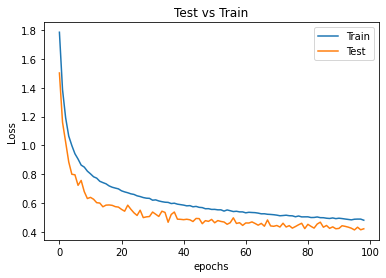

In [ ]:
plotter.plot_combined([ai.metrics['train_loss'], ai.metrics['test_loss']], y_label='Loss')

In [ ]:
results = plot_inference.Results(model, test_loader, DEVICE, mean, std, classes)

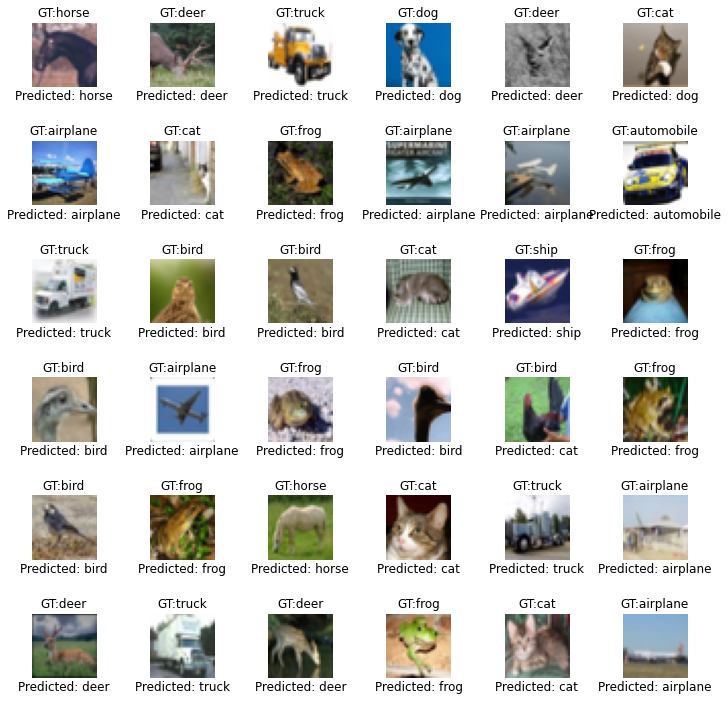

In [ ]:
results.plot_batch(6,6)

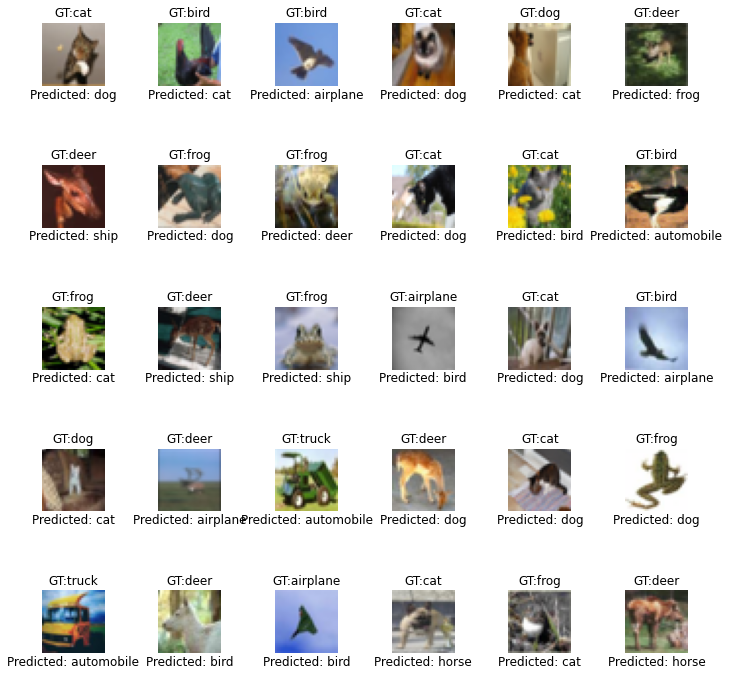

In [ ]:
results.plot_incorrect(5,6)

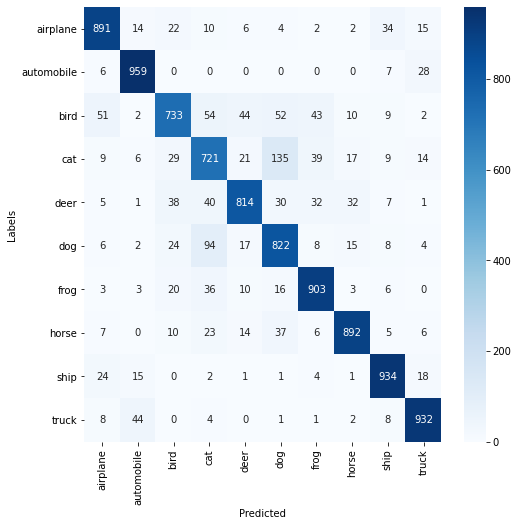

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class cat is 72.10
Accuracy of class bird is 73.30
Accuracy of class deer is 81.40
Accuracy of class dog is 82.20
Accuracy of class airplane is 89.10
Accuracy of class horse is 89.20
Accuracy of class frog is 90.30
Accuracy of class truck is 93.20
Accuracy of class ship is 93.40
Accuracy of class automobile is 95.90


In [ ]:
results.class_accuracy()